# Testing

Contines Coverage Path Planning tests for a single robot, not DARP.

**Important Metrics**
- Redundancy ($R$): percentage of points that are in excess of the visited points $V$, $L_{cpath}$ is the length of the coverage path. $R = \frac{L_{cpath}}{V} - 1$
- Coverage ($C$): percentage of points covered of the total that can be covered, $P_{nobs}$ are the number of points on the map that aren't obstacles. $C = \frac{V}{P_{nobs}}$

In [1]:
from cpp_algorithms import dist_fill
from cpp_algorithms import wavefront, bcd, stc
from cpp_algorithms import single_robot_multiple, single_robot_single
from cpp_algorithms import imshow, get_random_coords, is_valid, get_all_area_maps

from cpp_algorithms.fuel_path import splice_paths, get_fuel_paths
from cpp_algorithms.common_helpers import generate_no_obs_area_map
from cpp_algorithms.common_helpers import generate_point_obstacles
from cpp_algorithms.constants import OB, NO
from cpp_algorithms.coverage_path.pathing_helpers import has_isolated_areas

## Run Tests

In [2]:
# Required for animations.
# Don't forget to close the figure.
%matplotlib notebook 
area_maps = get_all_area_maps("test_maps")
point_maps = [generate_point_obstacles(am,p=0.05) for am in generate_no_obs_area_map()]

### Spanning Tree Coverage Algorithm

#### Without fuel paths.

In [3]:
"""
Using prepainted area_maps
"""
%time stc_non_fuel_test_am = single_robot_multiple(stc, area_maps)
stc_non_fuel_test_am


CPU times: user 1.06 s, sys: 20.8 ms, total: 1.08 s
Wall time: 1.17 s


,success,cp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape
0,True,0.009636,716,308,716,733,1.0,0.023743,"(32, 32)"
1,True,0.006498,689,335,689,703,1.0,0.020319,"(32, 32)"
2,True,0.005119,639,385,639,655,1.0,0.025039,"(32, 32)"
3,True,0.004744,654,370,654,679,1.0,0.038226,"(32, 32)"
4,True,0.006967,794,230,794,801,1.0,0.008816,"(32, 32)"
5,True,0.007607,725,299,725,739,1.0,0.019310,"(32, 32)"
6,True,0.007159,723,301,723,737,1.0,0.019364,"(32, 32)"
7,True,0.019763,610,414,610,867,1.0,0.421311,"(32, 32)"
8,True,0.018336,772,252,772,829,1.0,0.073834,"(32, 32)"
9,True,0.018500,1529,971,1529,1565,1.0,0.023545,"(50, 50)"


In [11]:
"""
Using randomly generated point obstacles 
with a probability of 0.04

Note : some tests will fail if there are locked in regions.
or if they are terminated cause of egregious run times.
"""
run = True
point_maps = [generate_point_obstacles(am,p=0.05) for am in generate_no_obs_area_map()]
for p in point_maps:
    if has_isolated_areas(p):
        run = False
        break
if run:
    %time stc_non_fuel_test_pm = single_robot_multiple(stc, point_maps)
run and stc_non_fuel_test_pm


CPU times: user 1.22 s, sys: 32 ms, total: 1.25 s
Wall time: 1.35 s


,success,cp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape
0,True,0.009163,974,50,974,1017,1.000000,0.044148,"(32, 32)"
1,True,0.021315,2356,144,2356,2485,1.000000,0.054754,"(50, 50)"
2,True,0.057395,6855,345,6855,7157,1.000000,0.044055,"(50, 144)"
3,True,0.438382,34896,1824,34758,36291,0.996045,0.044105,"(144, 255)"
4,True,0.731150,62245,3291,62245,65009,1.000000,0.044405,"(256, 256)"


#### With fuel paths.

In [12]:
"""
Using prepainted area_maps
"""
%time stc_oui_fuel_test_am = single_robot_multiple(stc, area_maps, fuel_paths=True)
stc_oui_fuel_test_am


CPU times: user 4.39 s, sys: 65.9 ms, total: 4.45 s
Wall time: 4.68 s


,success,cp_compute_time,fp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape,refuels,fuel_path_len,fuel_capacity,total_redundancy,max_dist_fuel
0,True,0.008147,0.041265,716,308,716,733,1.0,0.023743,"(32, 32)",8,174,103,0.244413,22
1,True,0.012091,0.024627,689,335,689,703,1.0,0.020319,"(32, 32)",5,172,155,0.255443,29
2,True,0.004495,0.030840,639,385,639,655,1.0,0.025039,"(32, 32)",4,120,167,0.200313,36
3,True,0.004095,0.019271,654,370,654,679,1.0,0.038226,"(32, 32)",3,166,226,0.282875,47
4,True,0.004456,0.032575,794,230,794,801,1.0,0.008816,"(32, 32)",5,160,168,0.197733,39
5,True,0.004476,0.034997,725,299,725,739,1.0,0.019310,"(32, 32)",4,114,208,0.165517,43
6,True,0.004701,0.010382,723,301,723,737,1.0,0.019364,"(32, 32)",4,282,220,0.398340,51
7,True,0.013083,0.072935,610,414,610,867,1.0,0.421311,"(32, 32)",1,82,556,0.552459,115
8,True,0.007245,0.056014,772,252,772,829,1.0,0.073834,"(32, 32)",3,132,240,0.237047,45
9,True,0.009614,0.047591,1529,971,1529,1565,1.0,0.023545,"(50, 50)",8,264,218,0.185742,44


<IPython.core.display.Javascript object>


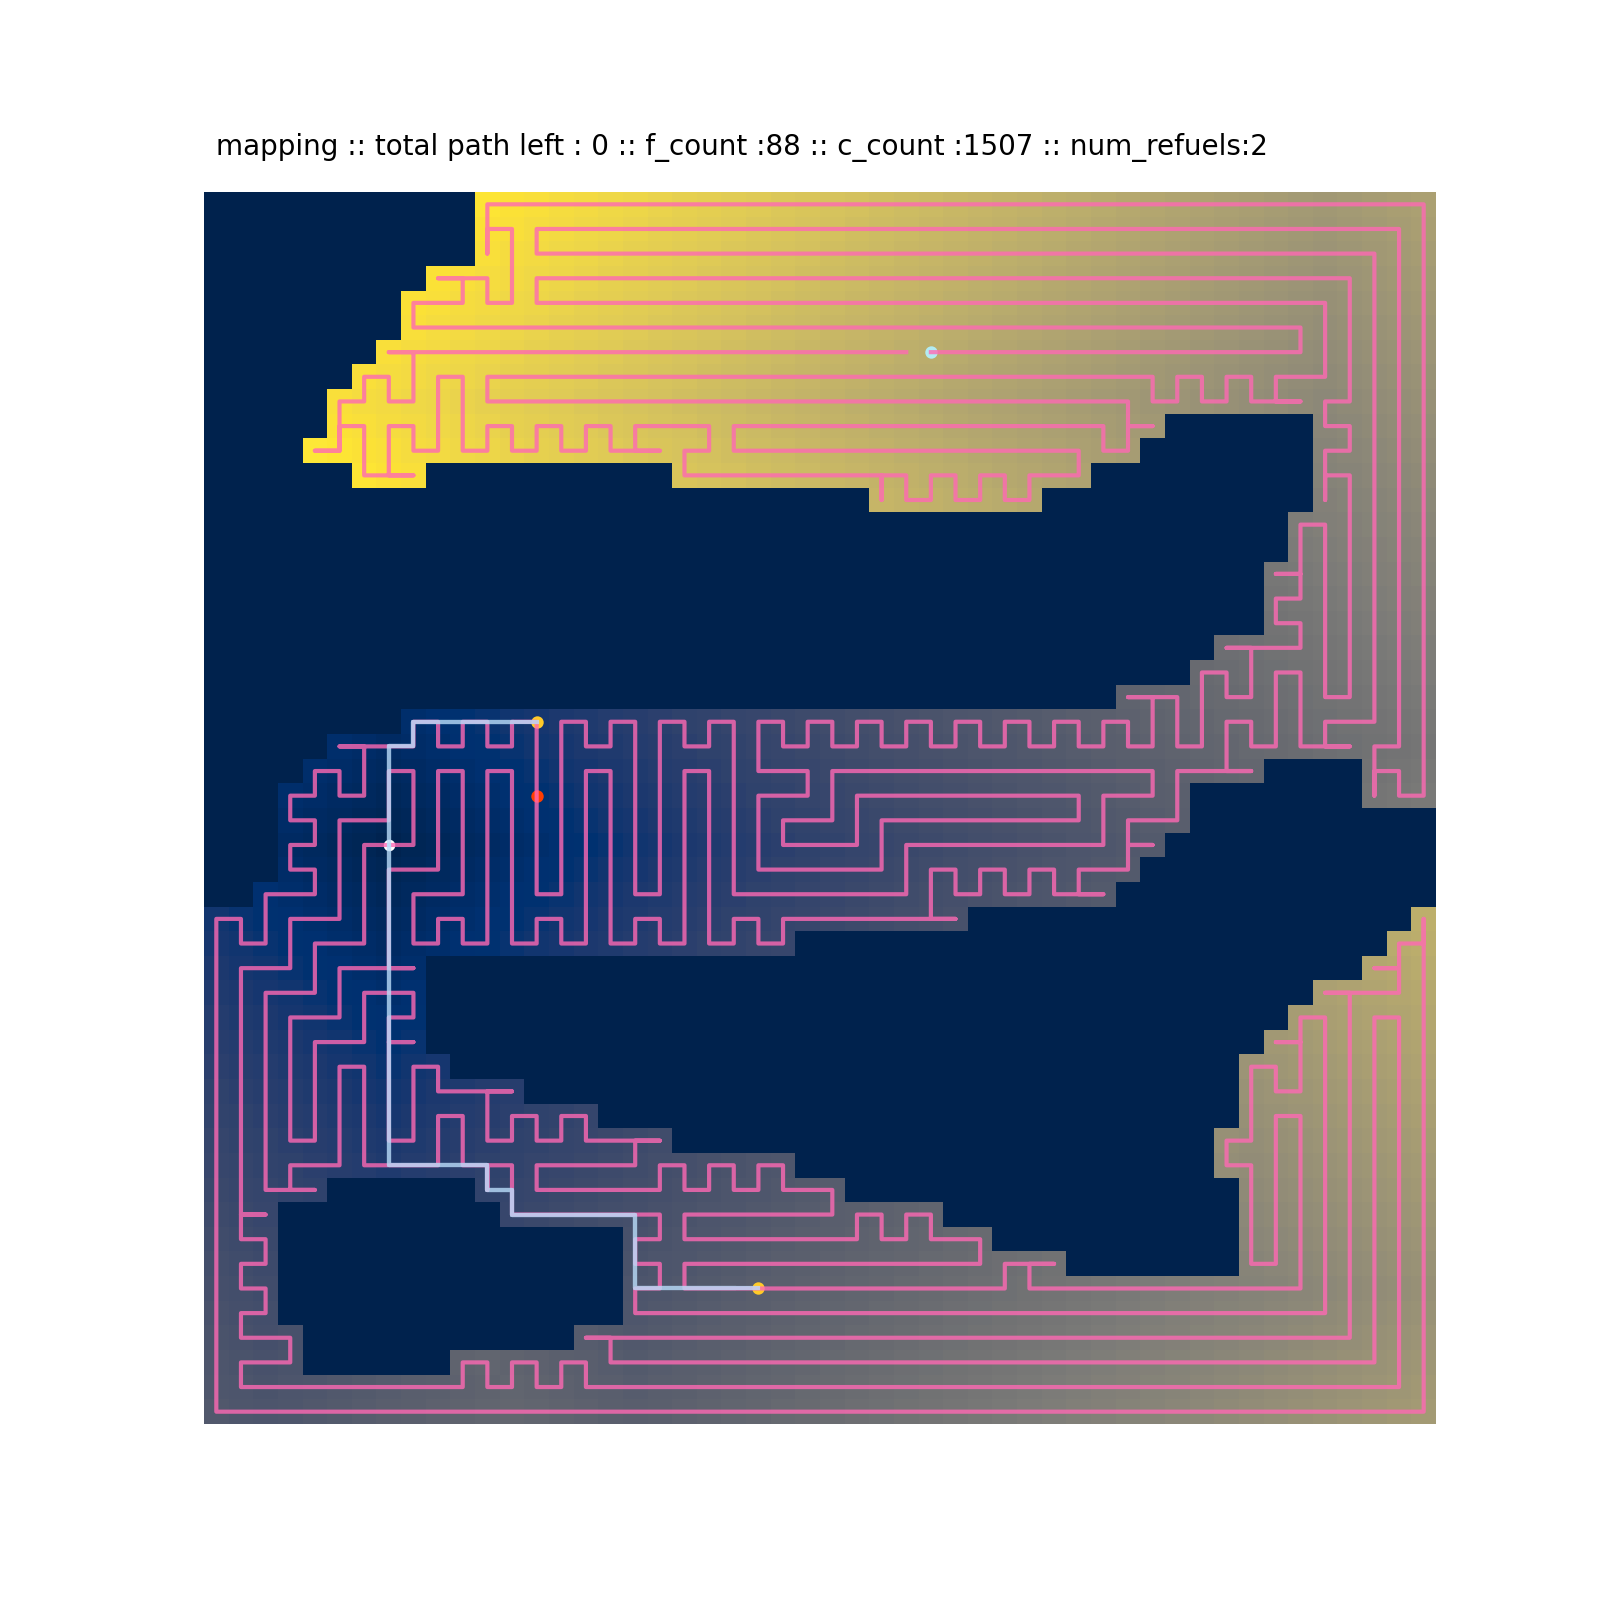

             success : True
     cp_compute_time : 0.018353939056396484
     fp_compute_time : 0.03232407569885254
     points_to_visit : 1472
     obstacle_points : 1028
      points_visited : 1472
   coverage_path_len : 1507
            coverage : 1.0
          redundancy : 0.02377717391304346
          area_shape : (50, 50)
             refuels : 2
       fuel_path_len : 92
       fuel_capacity : 546
    total_redundancy : 0.08355978260869557
       max_dist_fuel : 99


In [14]:
metrics, _ = single_robot_single(stc, area_maps[11], animate=True, interval=11, fuel_paths=True)

### Boustrophedon Cell Decomposition Algorithm

#### Without fuel paths.

In [4]:
"""
Using prepainted area_maps
"""
%time bcd_non_fuel_test_am = single_robot_multiple(bcd, area_maps)
bcd_non_fuel_test_am


CPU times: user 15.9 s, sys: 380 ms, total: 16.3 s
Wall time: 16.6 s


,success,cp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape
0,True,0.052879,716,308,716,791,1.0,0.104749,"(32, 32)"
1,True,0.050353,689,335,689,794,1.0,0.152395,"(32, 32)"
2,True,0.031907,639,385,639,788,1.0,0.233177,"(32, 32)"
3,True,0.036928,654,370,654,865,1.0,0.322630,"(32, 32)"
4,True,0.026672,794,230,794,911,1.0,0.147355,"(32, 32)"
5,True,0.020501,725,299,725,860,1.0,0.186207,"(32, 32)"
6,True,0.040836,723,301,723,849,1.0,0.174274,"(32, 32)"
7,True,0.084260,610,414,610,1280,1.0,1.098361,"(32, 32)"
8,True,0.065247,772,252,772,1068,1.0,0.383420,"(32, 32)"
9,True,0.056081,1529,971,1529,1700,1.0,0.111838,"(50, 50)"


In [10]:
"""
Using randomly generated point obstacles 
with a probability of 0.04

Note : some tests will fail if there are locked in regions.
or if they are terminated cause of egregious run times.
"""
run = True
point_maps = [generate_point_obstacles(am,p=0.05) for am in generate_no_obs_area_map()]
for p in point_maps:
    if has_isolated_areas(p):
        run = False
        break
if run:
    %time bcd_non_fuel_test_pm = single_robot_multiple(bcd, point_maps)
bcd_non_fuel_test_pm


CPU times: user 1min 35s, sys: 2.85 s, total: 1min 38s
Wall time: 1min 42s


,success,cp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape
0,True,0.142932,967,57,967,1259,1.0,0.301965,"(32, 32)"
1,True,0.265540,2385,115,2385,3005,1.0,0.259958,"(50, 50)"
2,True,1.147057,6865,335,6865,8575,1.0,0.249090,"(50, 144)"
3,True,24.398466,34873,1847,34873,44172,1.0,0.266653,"(144, 255)"
4,True,76.693851,62320,3216,62320,78702,1.0,0.262869,"(256, 256)"


##### Testing on dependence on random initialization of start and center points.

In [5]:
"""
Testing start point dependence, start points are randomly generated.
"""
area_map = area_maps[10]
%time bcd_non_fuel_test_am_random_sp = single_robot_multiple(bcd, [area_map] * 500)
print(bcd_non_fuel_test_am_random_sp[["redundancy","coverage_path_len"]].describe())


CPU times: user 53.5 s, sys: 944 ms, total: 54.4 s
Wall time: 56.8 s
       redundancy  coverage_path_len
count  500.000000         500.000000
mean     0.324212        1745.312000
std      0.031139          41.041436
min      0.261002        1662.000000
25%      0.301783        1715.750000
50%      0.326252        1748.000000
75%      0.341616        1768.250000
max      0.474962        1944.000000


##### Animating path movements
Running the test on a single area map with the animation.

<IPython.core.display.Javascript object>


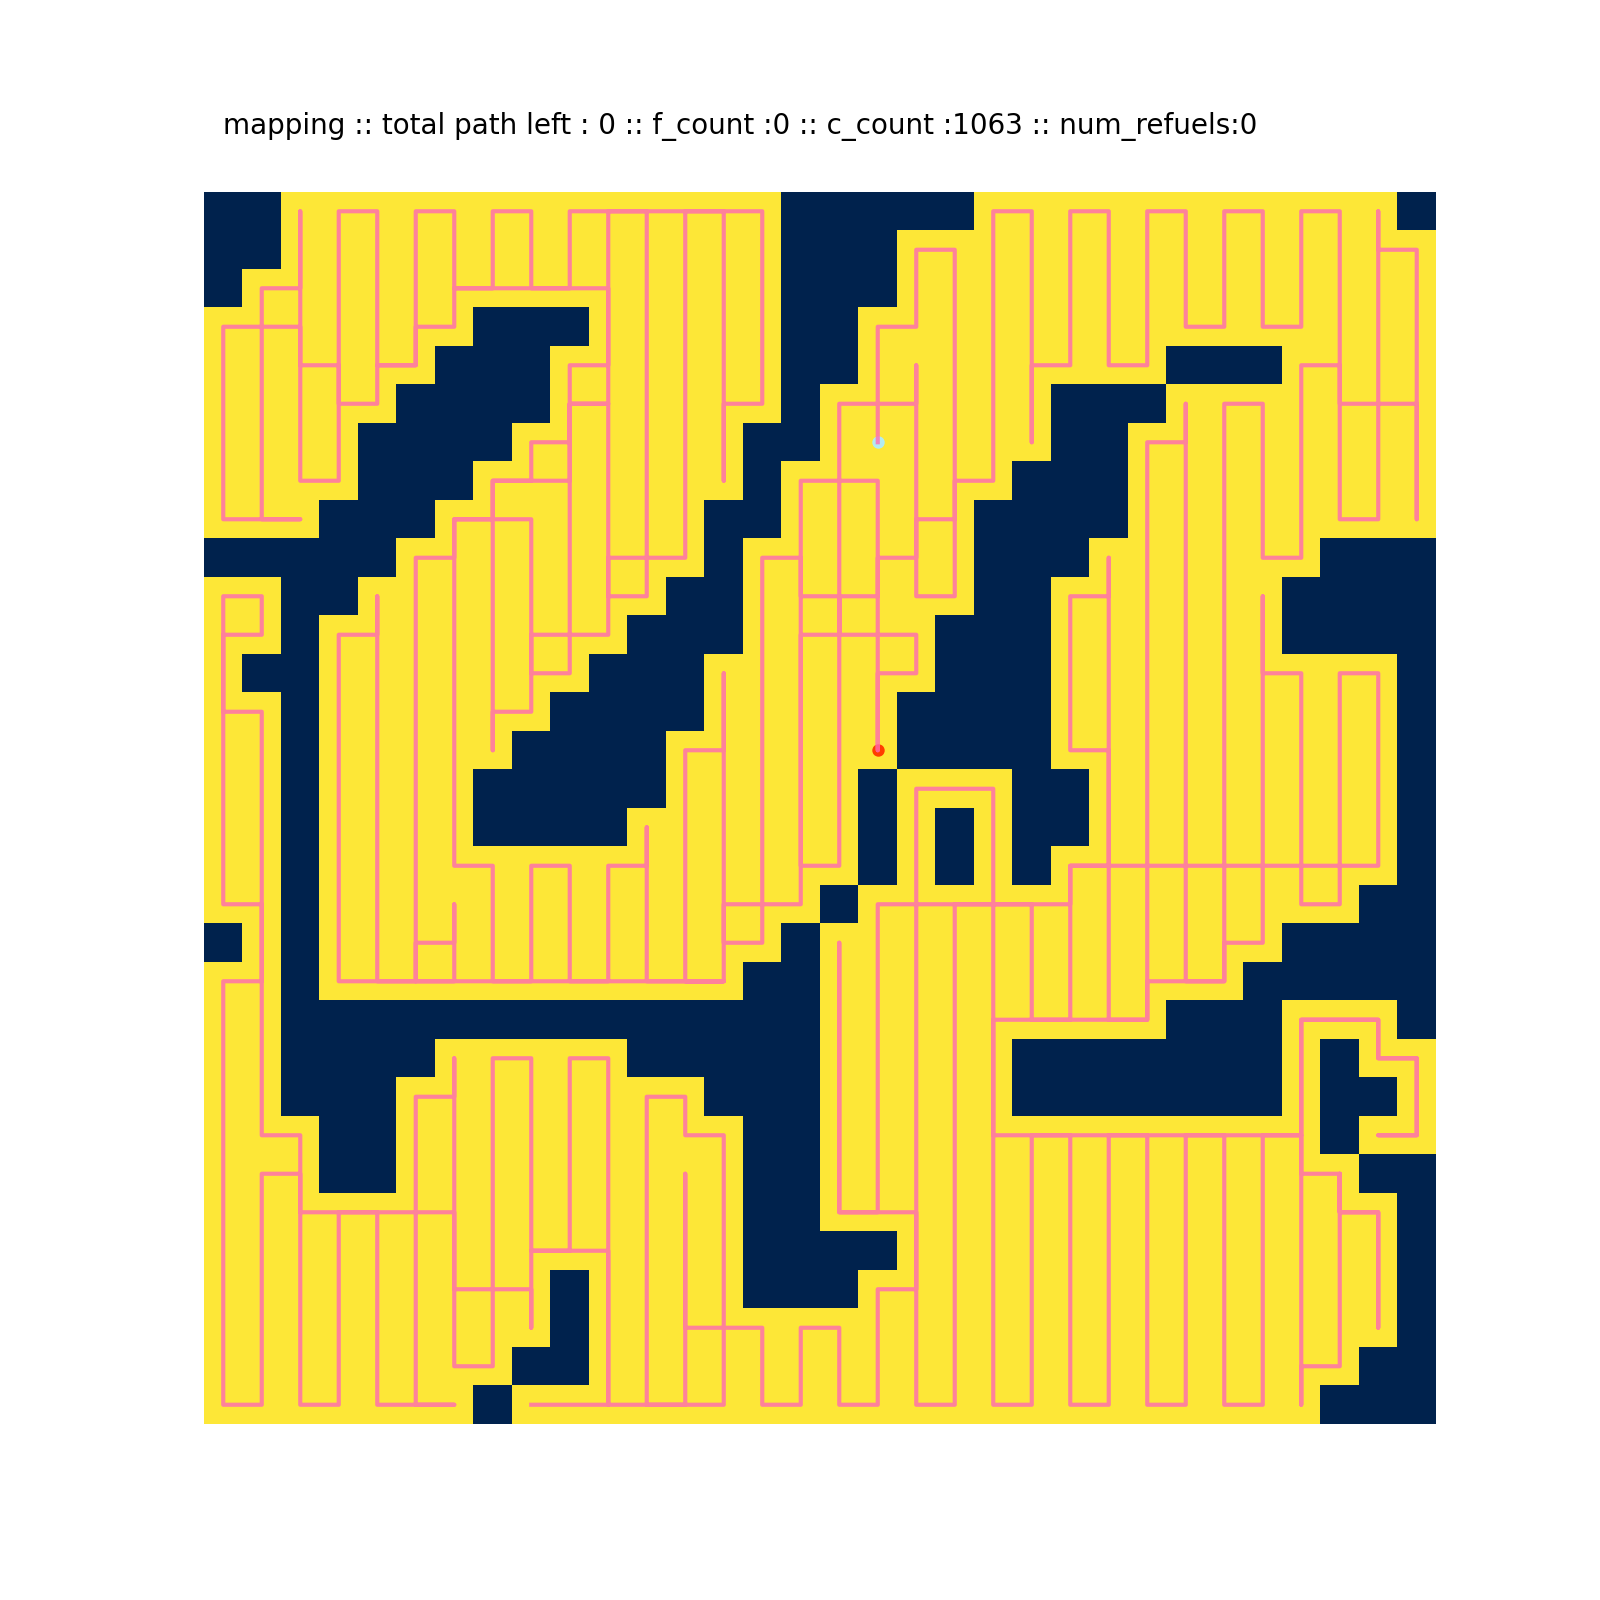

             success : True
     cp_compute_time : 0.15229415893554688
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 1063
            coverage : 1.0
          redundancy : 0.37694300518134716
          area_shape : (32, 32)


In [6]:
metrics, _ = single_robot_single(bcd, area_maps[8], animate=True, interval=1)

#### With fuel paths.

In [10]:
"""
Using prepainted area_maps
"""
%time bcd_oui_fuel_test_am = single_robot_multiple(bcd, area_maps, fuel_paths=True)
bcd_oui_fuel_test_am


CPU times: user 21.6 s, sys: 432 ms, total: 22.1 s
Wall time: 22.7 s


,success,cp_compute_time,fp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape,refuels,fuel_path_len,fuel_capacity,total_redundancy,max_dist_fuel
0,True,0.043412,0.030437,716,308,716,805,1.0,0.124302,"(32, 32)",10,172,94,0.336592,22
1,True,0.043993,0.007985,689,335,689,795,1.0,0.153846,"(32, 32)",3,188,283,0.417997,59
2,True,0.026824,0.012728,639,385,639,762,1.0,0.192488,"(32, 32)",8,214,118,0.502347,25
3,True,0.054360,0.008713,654,370,654,932,1.0,0.425076,"(32, 32)",3,158,296,0.657492,57
4,True,0.022051,0.012403,794,230,794,860,1.0,0.083123,"(32, 32)",4,150,215,0.261965,52
5,True,0.030248,0.016890,725,299,725,860,1.0,0.186207,"(32, 32)",5,176,189,0.415172,44
6,True,0.021038,0.008505,723,301,723,795,1.0,0.099585,"(32, 32)",3,246,305,0.431535,59
7,True,0.081827,0.012023,610,414,610,1241,1.0,1.034426,"(32, 32)",3,148,439,1.267213,89
8,True,0.068821,0.018647,772,252,772,1054,1.0,0.365285,"(32, 32)",5,150,216,0.546632,46
9,True,0.067445,0.019045,1529,971,1529,1775,1.0,0.160889,"(50, 50)",6,486,325,0.470896,70


<IPython.core.display.Javascript object>


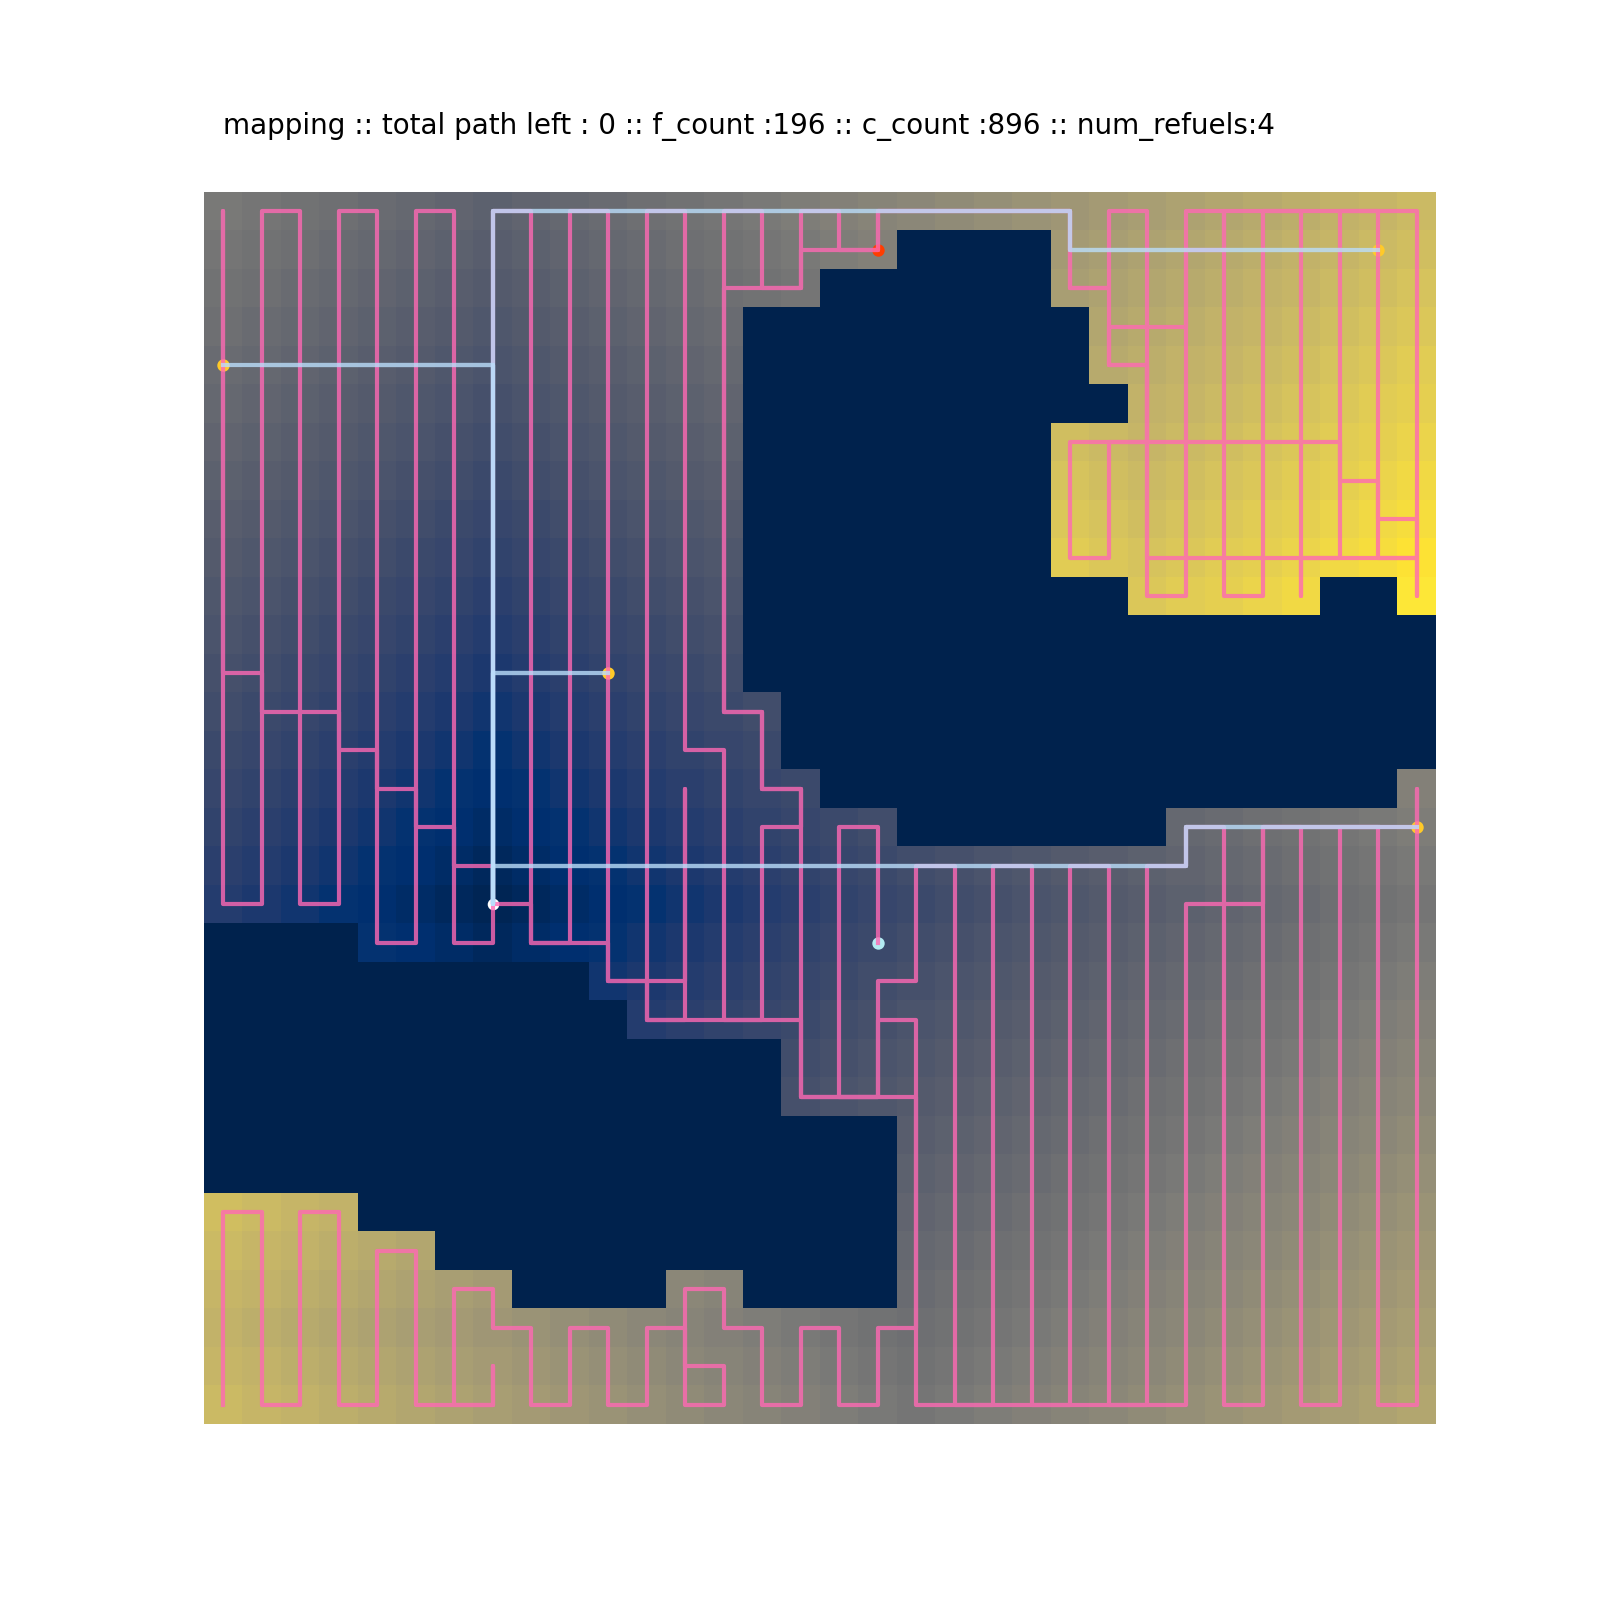

             success : True
     cp_compute_time : 0.040808916091918945
     fp_compute_time : 0.011070966720581055
     points_to_visit : 725
     obstacle_points : 299
      points_visited : 725
   coverage_path_len : 896
            coverage : 1.0
          redundancy : 0.2358620689655173
          area_shape : (32, 32)
             refuels : 4
       fuel_path_len : 204
       fuel_capacity : 234
    total_redundancy : 0.5062068965517241
       max_dist_fuel : 52


In [9]:
metrics, _ = single_robot_single(bcd, area_maps[5], animate=True, interval=4, fuel_paths=True)

### Wavefront Algorithm

#### Without fuel paths.

In [4]:
"""
Using prepainted area_maps
"""
%time wavefront_non_fuel_test_am = single_robot_multiple(wavefront, area_maps, no_end=True, fuel_paths=False)
wavefront_non_fuel_test_am


CPU times: user 25.3 s, sys: 142 ms, total: 25.4 s
Wall time: 25.9 s


,cp_compute_time,success,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape
0,0.103377,True,716,308,716,771,1.0,0.076816,"(32, 32)"
1,0.044060,True,689,335,689,747,1.0,0.084180,"(32, 32)"
2,0.039281,True,639,385,639,687,1.0,0.075117,"(32, 32)"
3,0.048845,True,654,370,654,749,1.0,0.145260,"(32, 32)"
4,0.057563,True,794,230,794,839,1.0,0.056675,"(32, 32)"
5,0.061015,True,725,299,725,780,1.0,0.075862,"(32, 32)"
6,0.058403,True,723,301,723,809,1.0,0.118949,"(32, 32)"
7,0.143846,True,610,414,610,836,1.0,0.370492,"(32, 32)"
8,0.064156,True,772,252,772,846,1.0,0.095855,"(32, 32)"
9,0.097987,True,1529,971,1529,1665,1.0,0.088947,"(50, 50)"


In [21]:
"""
Using randomly generated point obstacles 
with a probability of 0.04

Note : some tests will fail if there are locked in regions.
or if they are terminated cause of egregious run times.
"""
%time wavefront_non_fuel_test_pm = single_robot_multiple(wavefront, point_maps, no_end=True, fuel_paths=False)
wavefront_non_fuel_test_pm


CPU times: user 2min 3s, sys: 1.03 s, total: 2min 4s
Wall time: 2min 11s


,cp_compute_time,success,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape
0,0.119609,True,981.0,43.0,981.0,1053.0,1.0,0.073394,"(32, 32)"
1,0.634161,True,2389.0,111.0,2389.0,2695.0,1.0,0.128087,"(50, 50)"
2,4.448170,True,6868.0,332.0,6868.0,8841.0,1.0,0.287274,"(50, 144)"
3,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Testing on dependence on random initialization of start and center points.

In [26]:
"""
Testing center point dependence, center points are randomly generated.
"""
area_map = area_maps[10]
start_point = get_random_coords(area_map, 1)[0]
%time wavefront_non_fuel_test_am_random_cp = single_robot_multiple(wavefront, [area_map] * 500, no_end=True, fuel_paths=False, start_point=start_point)
print(wavefront_non_fuel_test_am_random_cp[["redundancy","coverage_path_len"]].describe())


CPU times: user 49.6 s, sys: 780 ms, total: 50.4 s
Wall time: 52.7 s
       redundancy  coverage_path_len
count  500.000000         500.000000
mean     0.091366        1438.420000
std      0.013447          17.722861
min      0.072838        1414.000000
25%      0.081184        1425.000000
50%      0.088012        1434.000000
75%      0.098634        1448.000000
max      0.135053        1496.000000


In [27]:
"""
Testing start point dependence, start points are randomly generated.
"""
area_map = area_maps[10]
center_point = get_random_coords(area_map, 1)[0]
%time wavefront_non_fuel_test_am_random_sp = single_robot_multiple(wavefront, [area_map] * 500, no_end=True, fuel_paths=False, center_point=center_point)
print(wavefront_non_fuel_test_am_random_sp[["redundancy","coverage_path_len"]].describe())


CPU times: user 1min 25s, sys: 1.14 s, total: 1min 26s
Wall time: 1min 31s
       redundancy  coverage_path_len
count  500.000000           500.0000
mean     0.075176          1417.0820
std      0.010261            13.5235
min      0.056146          1392.0000
25%      0.068285          1408.0000
50%      0.073596          1415.0000
75%      0.078907          1422.0000
max      0.125190          1483.0000


##### Animating path movements
Running the test on a single area map with the animation.

<IPython.core.display.Javascript object>


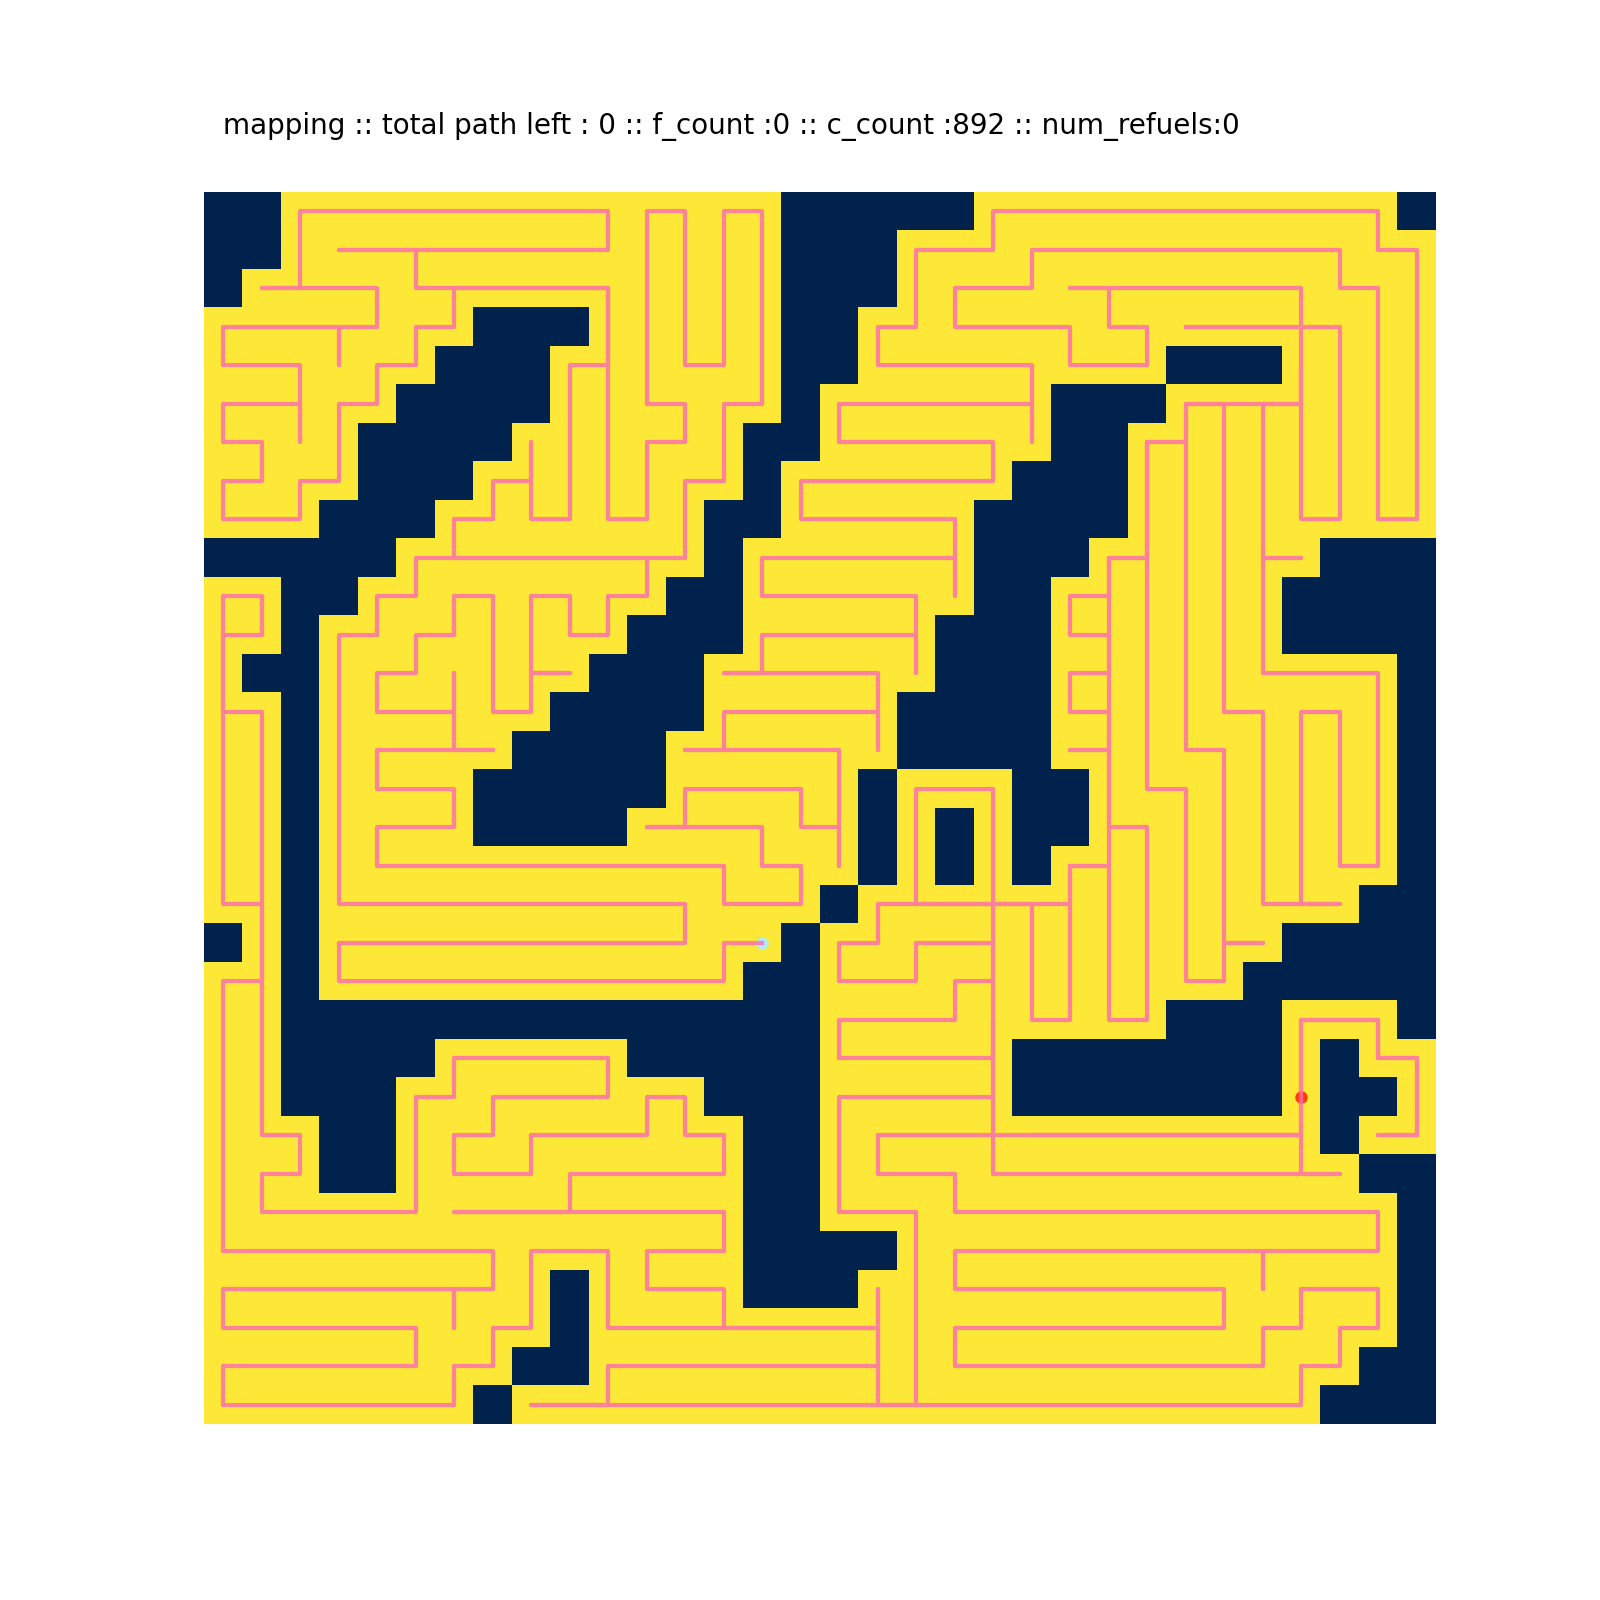

     cp_compute_time : 0.09020400047302246
     points_to_visit : 772
     obstacle_points : 252
      points_visited : 772
   coverage_path_len : 892
            coverage : 1.0
          redundancy : 0.15544041450777213
          area_shape : (32, 32)


In [7]:
metrics, _ = single_robot_single(wavefront, area_maps[8], animate=True, interval=1, fuel_paths=False)

#### With fuel paths.

In [5]:
"""
Using prepainted area_maps
"""
%time wavefront_oui_fuel_test_am = single_robot_multiple(wavefront, area_maps, no_end=True, fuel_paths=True)
wavefront_oui_fuel_test_am


CPU times: user 44.6 s, sys: 321 ms, total: 44.9 s
Wall time: 45.7 s


,success,cp_compute_time,fp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape,refuels,fuel_path_len,fuel_capacity,total_redundancy,max_dist_fuel
0,True,0.099260,0.013408,716,308,716,771,1.0,0.076816,"(32, 32)",5,102,146,0.205307,28
1,True,0.045389,0.006434,689,335,689,732,1.0,0.062409,"(32, 32)",4,140,188,0.253991,41
2,True,0.029358,0.003394,639,385,639,660,1.0,0.032864,"(32, 32)",2,44,237,0.095462,46
3,True,0.059041,0.007520,654,370,654,748,1.0,0.143731,"(32, 32)",3,176,278,0.403670,47
4,True,0.059784,0.005304,794,230,794,835,1.0,0.051637,"(32, 32)",3,158,263,0.243073,54
5,True,0.036853,0.007372,725,299,725,764,1.0,0.053793,"(32, 32)",2,72,290,0.147586,54
6,True,0.059338,0.014238,723,301,723,801,1.0,0.107884,"(32, 32)",4,122,211,0.265560,40
7,True,0.104559,0.010339,610,414,610,879,1.0,0.440984,"(32, 32)",1,36,626,0.496721,123
8,True,0.051446,0.011016,772,252,772,839,1.0,0.086788,"(32, 32)",4,152,241,0.273316,50
9,True,0.195774,0.020033,1529,971,1529,1742,1.0,0.139307,"(50, 50)",8,404,251,0.393067,53


In [6]:
"""
Using randomly generated point obstacles 
with a probability of 0.04

Didn't interrupt, point obstacles lead to high redundancy and compute time.
"""
run = True
point_maps = [generate_point_obstacles(am,p=0.05) for am in generate_no_obs_area_map()]
for p in point_maps:
    if has_isolated_areas(p):
        run = False
        break
if run:
    %time wavefront_non_fuel_test_pm = single_robot_multiple(wavefront, point_maps)
wavefront_non_fuel_test_pm


CPU times: user 7min 6s, sys: 2.26 s, total: 7min 8s
Wall time: 7min 17s


,success,cp_compute_time,fp_compute_time,points_to_visit,obstacle_points,points_visited,coverage_path_len,coverage,redundancy,area_shape,refuels,fuel_path_len,fuel_capacity,total_redundancy,max_dist_fuel
0,True,0.137538,0.012703,974,50,974,1117,1.0,0.146817,"(32, 32)",6,224,203,0.364476,41
1,True,0.382540,0.053559,2381,119,2381,2676,1.0,0.123898,"(50, 50)",12,646,262,0.385132,55
2,True,5.015504,0.088129,6853,347,6853,8318,1.0,0.213775,"(50, 144)",12,1514,771,0.431198,164
3,True,148.838211,0.519548,34919,1801,34919,44234,1.0,0.266760,"(144, 255)",29,9558,1817,0.538818,344
4,True,271.510691,5.097264,62238,3298,62238,77496,1.0,0.245156,"(256, 256)",60,10788,1452,0.416562,246


<IPython.core.display.Javascript object>


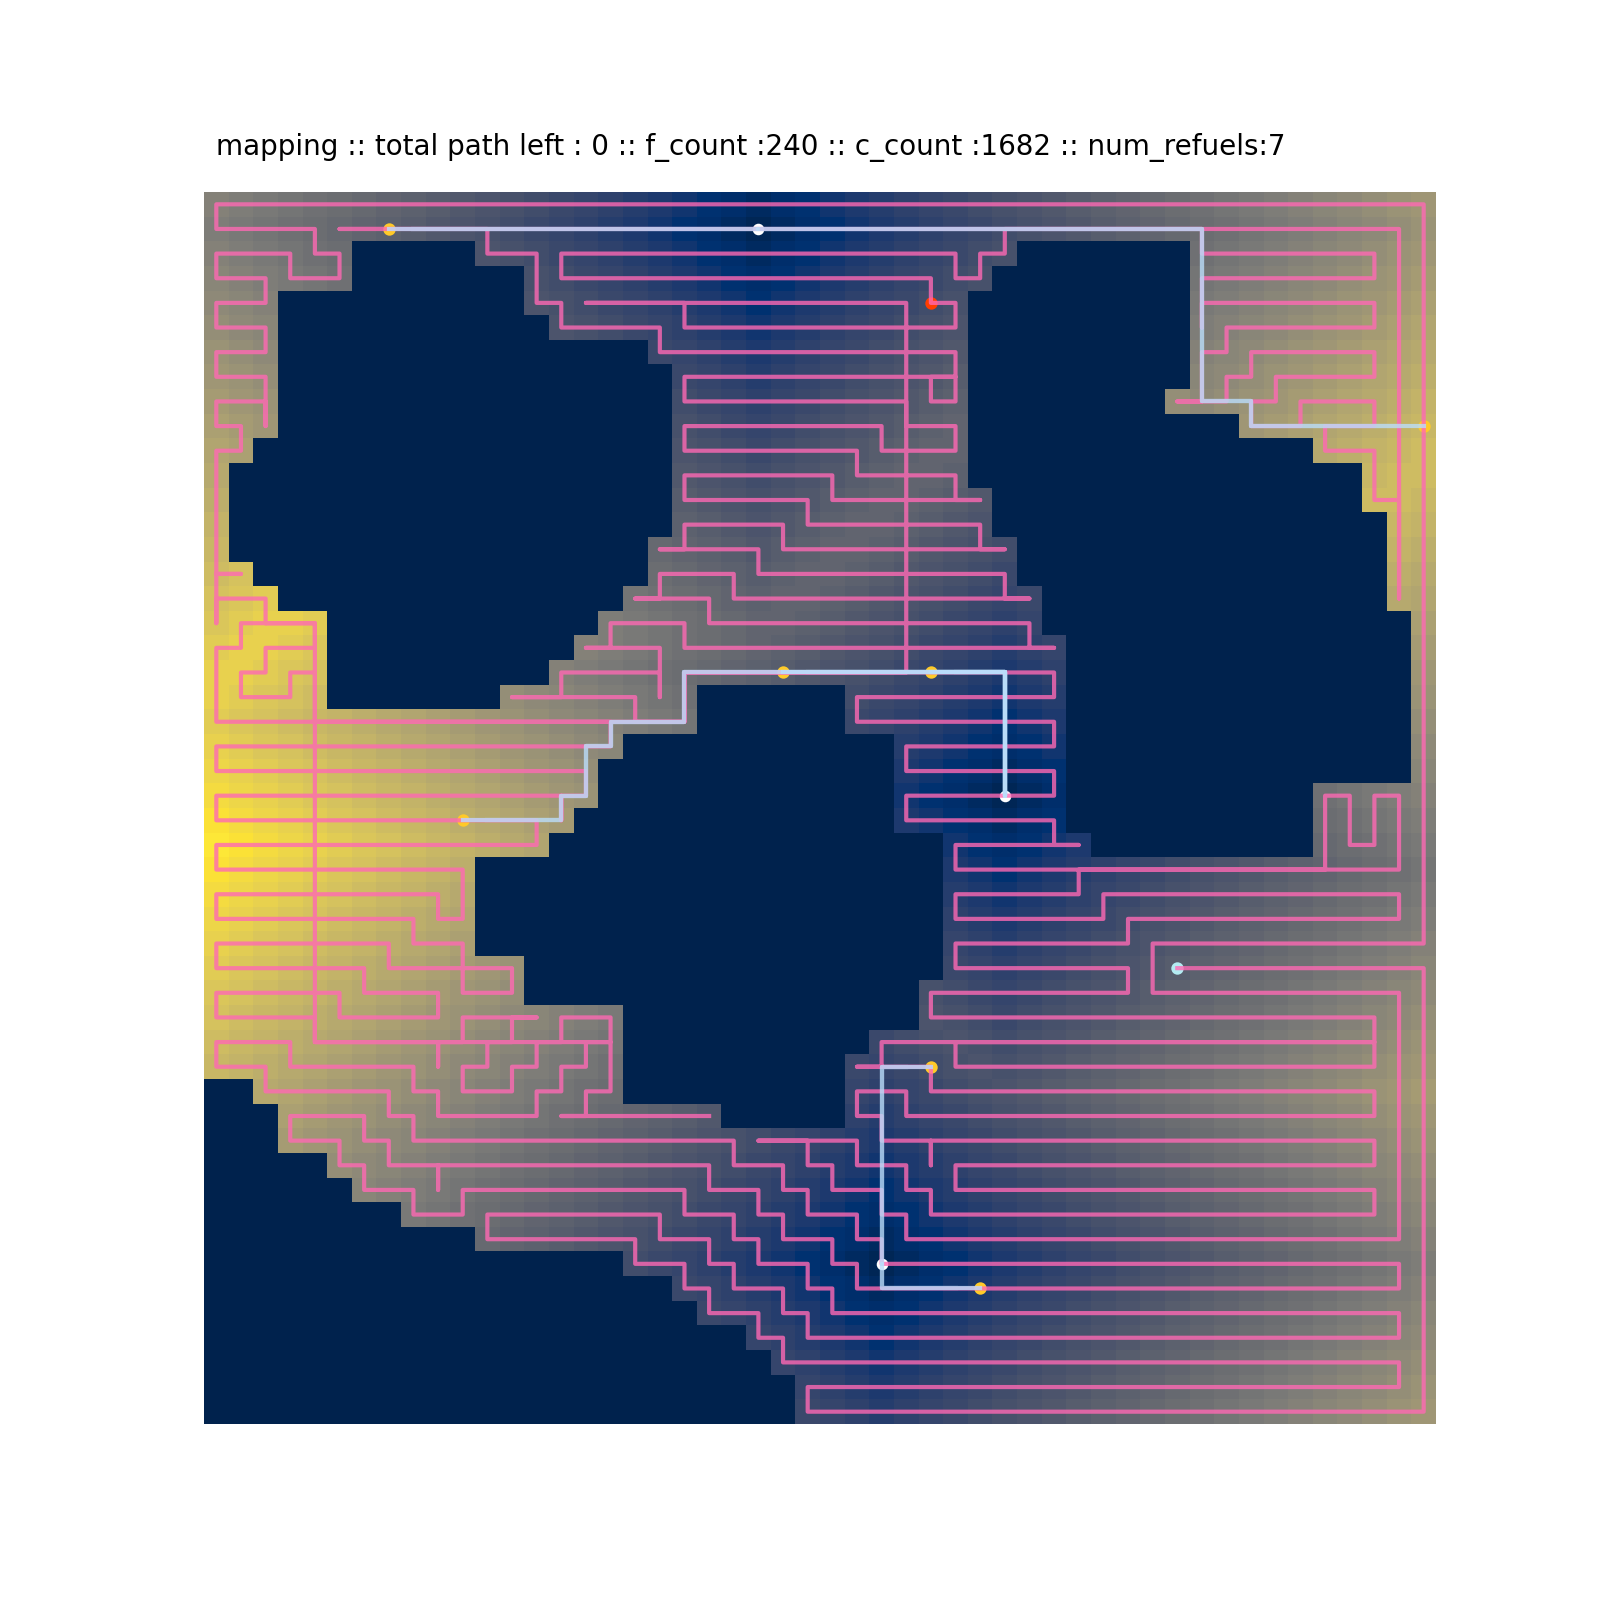

             success : True
     cp_compute_time : 0.19532418251037598
     fp_compute_time : 0.029817819595336914
     points_to_visit : 1529
     obstacle_points : 971
      points_visited : 1529
   coverage_path_len : 1682
            coverage : 1.0
          redundancy : 0.10006540222367555
          area_shape : (50, 50)
             refuels : 7
       fuel_path_len : 254
       fuel_capacity : 262
    total_redundancy : 0.25703073904512763
       max_dist_fuel : 44


In [4]:
metrics, _ = single_robot_single(wavefront, area_maps[9], animate=True, interval=1, fuel_paths=True)

# ToDo

## Path generation API
### Single Robot Path Generation
- Generate coverage path from given area map and list of relevant points (start, end, fuel).✅
- Generate fuel path from given fuel map and coverage path.✅
- Generate combined path.✅

### Multiple Robot Path Generation
- Obtain area division map from DARP.
- Pass area division map to all algos with relevant cell value to represent mapping area.
- Same interface as single robot path generation.

## Testing
### Functions to visualize
- Animation single robot✅
- Animation multiple robots
- Map Show single robot✅
- Map show multiple robots


### Metrics
- Single Robot✅
- Multiple Robots✅
#### Percents
- **Coverage** - Percentage of non obstacle cells covered by the path.✅
- **Redundancy** - Percentage of cells from the path that have been revisited (backtracked).✅

#### Timings
- **Coverage Path computation time** - Time taken by the algorithm to compute the coverage path.✅
- **Fuel Path computation time** - Time taken to compute the refuel path.✅

#### Numbers
- **Coverage cells** - Number of cells to be covered.✅
- **Non covered cells** - Cells that haven't been covered.✅
- **Backtrack** - Count of coverage path cells that have been revisited.✅
- **Coverage Path length** - Number of steps in the area coverage path.✅
- **Fuel Path length** - Number of steps in the refueling path.✅
    
### Running Tests On/Create maps for
- Resolutions, Get obstacle maps of the following resolutions.✅
    - (32, 32)✅
    - (50, 50)✅
    - (144, 50)✅
    - (256, 144)✅
    - (256, 256)✅
- Obstacle types
    - None✅
    - Point obstacles (single cell obstacles generated randomly).✅
    - Region obstacles (region obstacles that have been painted).✅
        - Corners✅
        - Central✅
        - Caves✅
        - Pipes, Bottlenecks✅
    - Combination of both.✅